In [41]:
import pymssql
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

conn = pymssql.connect(server='sql16ssd-014.localnet.kr', user='i2on11_admin', password='root0826', database='i2on11_admin')
cursor = conn.cursor()

tank_seq = '333'
conn_sql = 'SELECT signal_time, tank_remain_volume FROM gas_tank_volume_history where tank_seq = ' + tank_seq + 'ORDER BY signal_time DESC'

# 쿼리 실행
cursor.execute(conn_sql)

# 결과 가져오기
rows = cursor.fetchall()

# 연결 닫기
conn.close()

In [42]:
d_h = pd.DataFrame(rows, columns=['datetime', 'history'])
d_h.set_index('datetime', inplace=True)
d_h

,history
datetime,
2023-01-05 02:59:36,45
2023-01-04 02:59:42,50
2023-01-03 02:59:49,50
2023-01-02 02:59:55,55
2023-01-01 02:59:57,55
...,...
2022-06-24 03:21:59,65
2022-06-23 03:22:06,70
2022-06-22 03:22:14,75


In [43]:
d_h.values.shape

(224, 1)

In [44]:
# Differencing
diff_d_h = d_h.copy()
diff_d_h = diff_d_h['history'].diff()
diff_d_h = diff_d_h.dropna()
print('### Differenced Data ###') 
print(diff_d_h)

### Differenced Data ###
datetime
2023-01-04 02:59:42     5.0
2023-01-03 02:59:49     0.0
2023-01-02 02:59:55     5.0
2023-01-01 02:59:57     0.0
2022-12-31 03:00:05     0.0
                       ... 
2022-06-24 03:21:59     0.0
2022-06-23 03:22:06     5.0
2022-06-22 03:22:14     5.0
2022-06-21 03:22:24     5.0
2022-06-11 08:44:47   -35.0
Name: history, Length: 223, dtype: float64


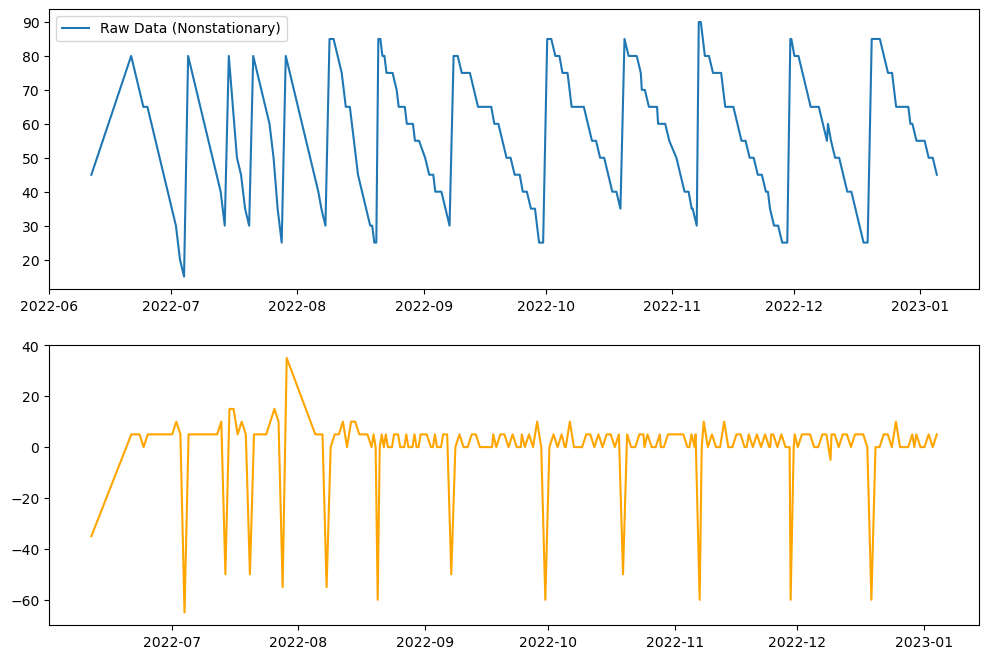

In [45]:
#Differenced data plot
plt.figure(figsize=(12,8)) 
plt.subplot(211)
plt.plot(d_h['history'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_d_h, 'orange') # first difference (t - (t-1)) plt.legend(['Differenced Data (Stationary)'])
plt.show()

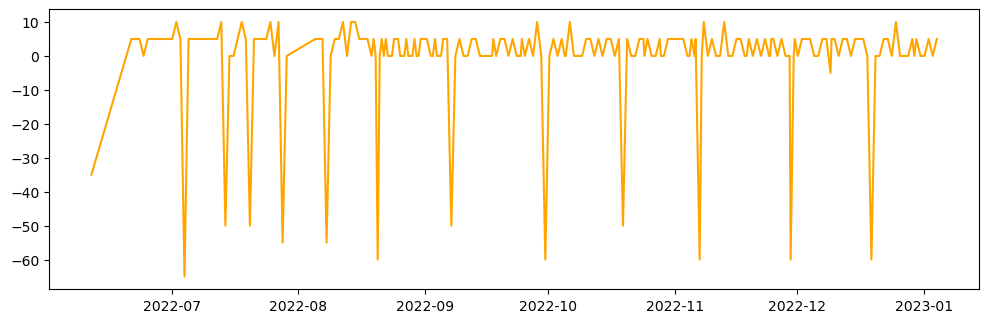

In [46]:
diff_d_h[diff_d_h >= 15] = 0
plt.figure(figsize=(12,8)) 
plt.subplot(212)
plt.plot(diff_d_h, 'orange') # first difference (t - (t-1)) plt.legend(['Differenced Data (Stationary)'])
plt.show()

<AxesSubplot:xlabel='datetime'>

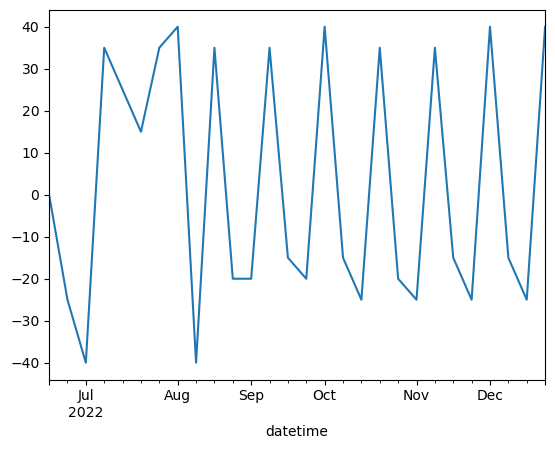

In [47]:
diff_d_h_weekly = -diff_d_h.resample('W').sum()
diff_d_h_weekly = diff_d_h_weekly.dropna()
# print(diff_d_h_weekly)
diff_d_h_weekly = diff_d_h_weekly.drop(diff_d_h_weekly.index[-1])
del diff_d_h_weekly[diff_d_h_weekly.index.min()]
del diff_d_h_weekly[diff_d_h_weekly.index.max()]
diff_d_h_weekly.plot()

<AxesSubplot:xlabel='datetime'>

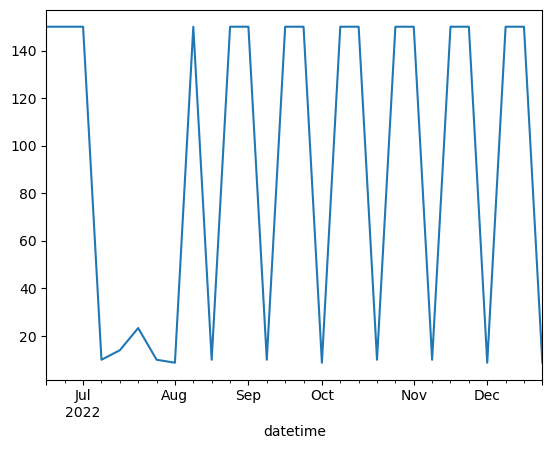

In [48]:
import numpy as np
max_cycle_value = 150
diff_cycle = round(50*7/(diff_d_h_weekly),2)
# print(diff_cycle)
diff_cycle[np.isneginf(diff_cycle)] = max_cycle_value
diff_cycle[diff_cycle < 0] = max_cycle_value
diff_cycle.plot()

In [68]:
def date_to_fraction(date):
    result = []
    for d in date:
        year = d.year
        month = d.month
        day = d.day

        days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

        if month < 1 or month > 12:
            raise ValueError("Invalid month value")

        days_to_month = days_in_month[month-1]
        day_of_month = sum(days_in_month[:month - 1]) + day
        #result.append(day_of_month)
        result.append(month + ((day-1)/days_to_month))
    return result

In [69]:
import pandas as pd
import numpy as np
H = nontime_date = date_to_fraction(diff_cycle.index)
W = diff_cycle.values
# Convert nontime_date to a pandas DataFrame
nontime_date = pd.DataFrame(nontime_date)
F = np.concatenate([[H], [W]])
tr_F = F.T

In [70]:
import numpy as np

# Convert H and W to numpy arrays
H = np.array(H)
W = np.array(W)

# Sort H and W by ascending order of H
sorted_indices = np.argsort(H)
sorted_H = H[sorted_indices]
sorted_W = W[sorted_indices]

# Transpose the arrays
data = F = np.vstack((sorted_H, sorted_W)).T
print(F)

[[  6.6        150.        ]
 [  6.83333333 150.        ]
 [  7.06451613 150.        ]
 [  7.29032258  10.        ]
 [  7.51612903  14.        ]
 [  7.74193548  23.33      ]
 [  7.96774194  10.        ]
 [  8.19354839   8.75      ]
 [  8.41935484 150.        ]
 [  8.64516129  10.        ]
 [  8.87096774 150.        ]
 [  9.1        150.        ]
 [  9.33333333  10.        ]
 [  9.56666667 150.        ]
 [  9.8        150.        ]
 [ 10.03225806   8.75      ]
 [ 10.25806452 150.        ]
 [ 10.48387097 150.        ]
 [ 10.70967742  10.        ]
 [ 10.93548387 150.        ]
 [ 11.16666667 150.        ]
 [ 11.4         10.        ]
 [ 11.63333333 150.        ]
 [ 11.86666667 150.        ]
 [ 12.09677419   8.75      ]
 [ 12.32258065 150.        ]
 [ 12.5483871  150.        ]
 [ 12.77419355   8.75      ]]


In [71]:
import matplotlib.pyplot as plt
from numpy import arange, ones, pi
from scipy import cos, sin
from scipy.fftpack import fft, fftfreq, ifft
# 주파수 구하기
N = data.shape[0]
dt = data[1, 0] - data[0, 0]
freq = np.fft.fftfreq(N, d=dt)

# 푸리에 변환하기
yf = fft(data[:, 1])
xf = freq

# 푸리에 근사치 구하기
num_coeff = 10 # 사용할 계수 수
yf_approx = np.zeros_like

[ 6.6         6.83333333  7.06451613  7.29032258  7.51612903  7.74193548
  7.96774194  8.19354839  8.41935484  8.64516129  8.87096774  9.1
  9.33333333  9.56666667  9.8        10.03225806 10.25806452 10.48387097
 10.70967742 10.93548387 11.16666667 11.4        11.63333333 11.86666667
 12.09677419 12.32258065 12.5483871  12.77419355]


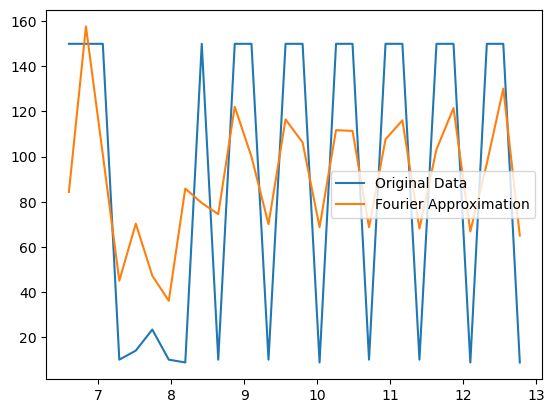

In [72]:
# 계수 추출
yf_trunc = np.zeros_like(yf)
yf_trunc[:num_coeff] = yf[:num_coeff]

# 역변환
y_approx = np.real(ifft(yf_trunc))
print(data[:,0])
# 플롯
plt.plot(data[:, 0], data[:, 1], label='Original Data')
plt.plot(data[:, 0], y_approx, label='Fourier Approximation')
plt.legend()
plt.show()

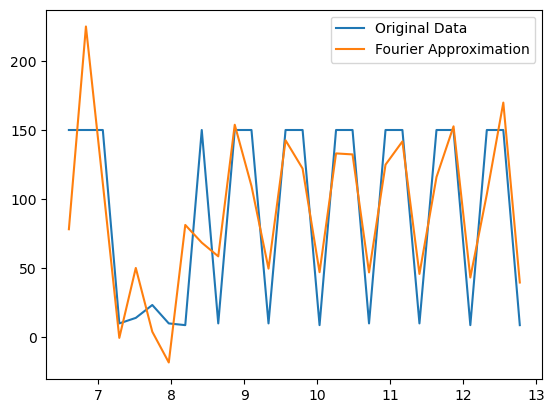

In [73]:
def fsl(x,a,b):
    return a*x+b
from scipy.optimize import curve_fit
import numpy as np
H = y_approx
W =  data[:, 1]
popt, pcov = curve_fit(fsl, H, W)

modelf = lambda x: fsl(x, *popt)

plt.plot(data[:, 0], data[:, 1], label='Original Data')
plt.plot(data[:, 0], fsl(H, *popt), label='Fourier Approximation')
plt.legend()
plt.show()

In [78]:
def fslvalue_per_day(x1, x2):
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    x = x1 + x2/(days_in_month[x1 - 1]+1)
    yf_trunc = np.zeros_like(yf)
    yf_trunc[:num_coeff] = yf[:num_coeff]
    y_interp = np.interp(x, data[:, 0], np.real(ifft(yf_trunc)))
    return y_interp

def remainby_cycle(x,remain):
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    warning = [40, 30, 20]
    while remain >=10:
        fsl_cycle_value = fsl(fslvalue_per_day(*x), *popt)
        if fsl_cycle_value < min(data[:,1]):
            fsl_cycle_value = min(data[:,1])
        used_gas = 50/fsl_cycle_value
        if remain>warning[0] and remain - used_gas <= warning[0]:
            print(warning[0],"Warning", x[0],".",x[1], " : ",round(remain - used_gas,3))
        elif remain>warning[1] and remain - used_gas <= warning[1]:
            print(warning[1],"Warning", x[0],".",x[1], " : ",round(remain - used_gas,3))
        elif remain>warning[2] and remain - used_gas <= warning[2]:
            print(warning[2],"Warning", x[0],".",x[1], " : ",round(remain - used_gas,3))
        remain = remain - used_gas
#         print( x[0],".",x[1], " : ",round(remain,3))
        if remain <=10:
            break
        x[1] = x[1]+1
        if x[1] > days_in_month[x[0]-1]:
            x[1] = x[1] - days_in_month[x[0]-1]
            x[0] = x[0]+1
        if x[0] > 12:
            x[0] = x[0]-12
    print( x[0],".",x[1], " : ",round(remain,3))
    return x 

In [79]:
x = [11,5]
fsl_cycle_value = fsl(fslvalue_per_day(*x), *popt)
print(x[0],"월",x[1],"일","80->30 cycle : ", round(fsl_cycle_value,3))
print(x[0],"월",x[1],"일","30->20 cycle : ", round(fsl_cycle_value/5,3))

if round(fsl_cycle_value/5,3) < 5:
    print("30% 알람 필요")
elif round(fsl_cycle_value/5,3) < 10:
    print("20% 알람 필요")
else:
    print("15% 알람 필요")

11 월 5 일 80->30 cycle :  141.334
11 월 5 일 30->20 cycle :  28.267
15% 알람 필요


In [80]:
x = [11, 5]
remain = 80
remainby_cycle(x,remain)

40 Warning 1 . 7  :  39.433
30 Warning 1 . 22  :  29.839
20 Warning 2 . 7  :  19.605
2 . 23  :  9.371


[2, 23]

In [81]:
x = [3, 3]
remain = 83
remainby_cycle(x,remain)

40 Warning 5 . 9  :  39.507
30 Warning 5 . 24  :  29.913
20 Warning 6 . 9  :  19.679
7 . 1  :  9.613


[7, 1]